In [1]:
import graphviz
import pydot
import pywrapfst as pfst
from pywrapfst import compose
# import fst
import nltk
import re
import os
from fst_funcs import analyse_state, get_lex, get_lang, get_rm_dupes, get_rm_blanks, speech_to_text, add_blank_loops, create_frame_acceptor
import numpy as np
import csv
import editdistance
from multiprocessing.dummy import Pool as ThreadPool 

%load_ext line_profiler
%load_ext memory_profiler

In [2]:
LM_expr = "^(.*)\.pru$"
folder_name = "../lang_model"
file_list = [os.path.join(folder_name, fname) for fname in os.listdir(folder_name)]
pruned_models = [re.match(LM_expr, filename).group(1) for filename in file_list if re.match(LM_expr, filename)]
pruned_models

['../lang_model/3-gram-1',
 '../lang_model/3-gram-3',
 '../lang_model/3-gram-0',
 '../lang_model/3-gram-2']

In [3]:
lang_model_name = folder_name+"/3-gram-3.pru"
lang_loaded = pfst.Fst.read(lang_model_name)

In [4]:
st_w_blank = pfst.SymbolTable().read_text("phoneme-symb-table-with-blank.txt")
st_no_blank = pfst.SymbolTable().read_text("phoneme-symb-table.txt")

In [5]:
lex_loaded = pfst.Fst.read("../lex_model/lex-uw.fst")
def word_end_iter():
    for i in range(40, 53):
        yield (i, 0)

lex_loaded = pfst.Fst.read("../lex_model/lex-uw.fst")
i_table = lex_loaded.input_symbols()
o_table = lex_loaded.output_symbols()
lang = pfst.Fst.read(lang_model_name )


In [6]:
LG = pfst.compose(lex_loaded, lang_loaded)


In [7]:
LG = pfst.determinize(LG)
LG=LG.minimize()
LG=LG.rmepsilon()
# LG = LG.push()
for i in range(40,53):
    LG.relabel_pairs(word_end_iter())
    print "Relabelled <w{}>".format(i)
LG = LG.set_input_symbols(st_no_blank)

Relabelled <w40>
Relabelled <w41>
Relabelled <w42>
Relabelled <w43>
Relabelled <w44>
Relabelled <w45>
Relabelled <w46>
Relabelled <w47>
Relabelled <w48>
Relabelled <w49>
Relabelled <w50>
Relabelled <w51>
Relabelled <w52>


In [8]:
nltk.corpus.cmudict.dict()["plato"]

[[u'P', u'L', u'EY1', u'T', u'OW0']]

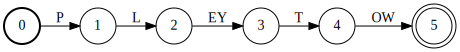

In [9]:
test_phons_w_blank = create_frame_acceptor("P L EY EY - - T T - OW OW", st_w_blank)
test_phons_no_blank = create_frame_acceptor("P L EY T OW", st_no_blank)
test_phons_no_blank

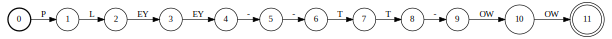

In [10]:
test_phons_w_blank

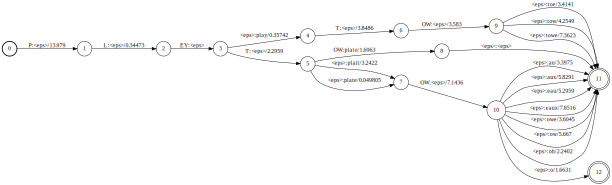

In [11]:
pfst.compose(test_phons_no_blank, LG)

In [12]:
rm_dupes = get_rm_dupes()
rm_blanks = get_rm_blanks()
reducer = pfst.compose(rm_dupes, rm_blanks)

In [13]:
pfst.compose(test_phons_w_blank, reducer)

In [14]:
full_fst = pfst.compose(reducer, LG)

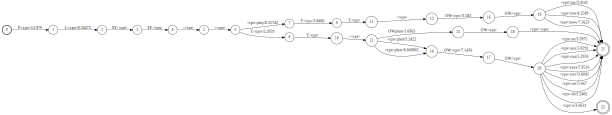

In [15]:
pfst.compose(test_phons_w_blank, full_fst)
# Why is there weight on arcs with a non-word output? 
# Does pfst correctly push weight of the language model??

In [16]:
# full_fst.push()
# pfst.compose(test_phons_w_blank, full_fst)
# Why is there weight on arcs with a non-word output? 
# Does pfst correctly push weight of the language model??

In [17]:
#full_fst.write("full_fst_2.fst")

In [18]:
# full_fst = add_blank_loops(LG)
# full_fst.write("full_fst_only_blank_loops.fst")

In [19]:
def get_extensions_inner(fst, state, used_move, passed_word, last_arc, input_idx, store):

    extensions = []
#     print "Getting extensions from {} using {}".format(state, input_idx)
#     print "Last arc is {}".format(last_arc)
    if not store.get(state,None):
#         print state
        arcs = fst.arcs(state)
        store[state] = {}
        state_store = store[state]
        for arc in arcs:
#             print arc.ilabel
            store[state][arc.ilabel] = arc
    else:
        state_store = store[state]
    eps_arc = state_store.get(0, None)
    idx_arc = state_store.get(input_idx, None)
    
    if eps_arc:
        extensions.extend(get_extensions_inner(fst, eps_arc.nextstate, used_move, eps_arc.olabel, eps_arc, input_idx, store))
        
    if idx_arc and not used_move:
        extensions.extend(get_extensions_inner(fst, idx_arc.nextstate, True, passed_word, idx_arc, input_idx, store))
    if extensions:
        return [[(last_arc, state)]+ext for ext in extensions] + ([[(last_arc,state)]] if last_arc and  last_arc.ilabel!=0 else [])
    else:
        return [[(last_arc,state)]]
    
def get_extensions(fst, start_state, input_idx, store):
    x= [a[1:] for a in get_extensions_inner(fst, start_state, False, False, None, input_idx, store) if a[1:]]
    return x

In [20]:
get_extensions(pfst.compose(test_phons_no_blank, LG), 2, st_w_blank.find("EY"), {})

[[(<Arc at 0x7fbd91f9db50>, 3), (<Arc at 0x7fbd91f9db30>, 4)],
 [(<Arc at 0x7fbd91f9db50>, 3)]]

In [21]:
def beam_search_full_comp(fst, probs, T, init_weight, width, alpha, beta, store):
    n_phons_incl_blank = 40
    
        
    root = fst.start()
    hyps = [[(None, root.__int__())]]
    weights = [init_weight]
    outs = [[]]
    out_idxs = [[]]
    input_symbols = fst.input_symbols()
    output_symbols = fst.output_symbols()
    print "T = {}".format(T)
    nlps = -np.log(probs)
    for t in range(T):
#         print "t={}, H = {}".format(t, outs)
        new_hyps = []
        new_weights = []
        new_outs = []
        for k, h in enumerate(hyps):
#             print "Extending {}".format([])
            for phon_symb_idx in range(1, n_phons_incl_blank+1):
                exts = get_extensions(fst, h[-1][1], phon_symb_idx, fst_store) 
                for ext in exts:
                    
                    final_ext_arc, final_ext_state = ext[-1] # the extension always ends on the word outputting arc
                    ext_word = final_ext_arc.olabel
                    new_hyps.append(h+ext) 
                    w_e = sum([l.weight.__float__() for l, x in ext]) * alpha
                    if ext_word != 0:
                        # non-epsilon output symbol
                        w_e  = w_e - beta * alpha
                        new_word = output_symbols.find(ext_word)
                        new_outs.append(outs[k]+[new_word])
                    else:
                        new_outs.append(outs[k])
                        
                        # non-epsilon input symbol
                        phon_probs_idx = phon_symb_idx-1
                        w_e = w_e + nlps[t][phon_probs_idx]

                    new_weights.append(weights[k] + w_e)
                
        best_hyp_idxs = np.argsort(new_weights)[:width]
        hyps =     [new_hyps[j]     for j in best_hyp_idxs]
        weights =  [new_weights[j]  for j in best_hyp_idxs]
        outs =     [new_outs[j]     for j in best_hyp_idxs]
        
    final_hyp_idxs = [i for i in range(len(hyps)) if fst.final(hyps[i][-1][1]).to_string != "Infinity"]
    final_outs = [outs[i] for i in final_hyp_idxs]
    final_weights = [weights[i] for i in final_hyp_idxs]
    return final_outs, final_weights

In [22]:
test_probs = np.load("../../acoustic/densenet_phon_nospace_b3.l5.f128.k7.relu_test_probs.npy")
test_probs.shape

(2836, 500, 40)

In [23]:
phon_measures = np.load("../phon_measures.npy")
test_likes = test_probs / phon_measures
test_likes.shape

(2836, 500, 40)

In [24]:
test_input_lens = np.load("../../acoustic/test_input_lens.npy")
test_input_lens.shape

(2836,)

In [25]:
test_ids = np.load("../../acoustic/test_ids.npy")
test_ids.shape
print test_ids[0]

2961-960-0002.flac


In [26]:
test_word_label_file = open("../../acoustic/asset/data/preprocess/meta/test_word.csv", "r")
csv_reader = csv.reader(test_word_label_file)
all_test_word_labels = {a[0]:a[1:] for a in csv_reader}
test_word_labels = []
for point_id in test_ids:
    test_word_labels.append(all_test_word_labels[point_id])

In [27]:
def beam_search_wrapper(fst, width, alpha, beta, init_weight, store):
    return lambda x: beam_search_full_comp(fst, 
                                              x[0], \
                                              x[1],\
                                              init_weight, \
                                              width , \
                                              alpha ,\
                                              beta,
                                              store)

WIDTH = 50
ALPHA = 0.6
BETA = 1.
INIT_WEIGHT = 0.
fst_store = {}
for ph in full_fst.states():
    fst_store[ph] = {}

In [30]:
def test_beam_search(idxs):
    pool = ThreadPool(4) 
    results = pool.map(beam_search_wrapper(full_fst, WIDTH, ALPHA, BETA, INIT_WEIGHT, fst_store), 
                       zip(test_likes[idxs], test_input_lens[idxs]))
    pool.close() 
    pool.join() 
#     results = [beam_search_wrapper(full_fst, WIDTH, ALPHA, BETA, INIT_WEIGHT, fst_store)(x) for x in zip(test_likes[idxs], test_input_lens[idxs])]
    # lowest weight is always first
    best_out, best_weight = results[0]
#     print results[0]
    total_true_words = 0
    total_errs = 0
    for i, pair in enumerate(results):
        outs, weights = pair
        best_out, best_weight = outs[0], weights[0]
        true_words = test_word_labels[idxs[i]]
        lev_dist = editdistance.eval(best_out, true_words)
        n_words = len(true_words)
        total_errs += lev_dist
        total_true_words += n_words
        print "Prediction:"
        print " ".join(best_out), best_weight
        print
        print "True answer:"
        print " ".join(true_words)
        print
        print "Levenshtein distance: {}/{}".format(editdistance.eval(best_out, true_words), len(true_words))
        break
    wer = float(total_errs)/total_true_words
    print "Final WER: {}".format(wer)

In [31]:
%lprun -f beam_search_full_comp test_beam_search(range(4))

T = 480T = 324

T = 492T = 239

Prediction:
it ghost severe styled neo applied tonnage stay saw hidden with germs wish tindell and sundance until doctoral nee squire tattoo variance ispra dove plaited -502.153213614

True answer:
in the supposed depths of this dialogue the neo platonists found hidden meanings and connections with the jewish and christian scriptures and out of them they elicited doctrines quite at variance with the spirit of plato

Levenshtein distance: 32/36
Final WER: 0.888888888889


In [166]:
lev_dist

NameError: name 'lev_dist' is not defined

In [ ]:
lex, lang = get_lex(64000), get_lang(lang_model_name)
lexlang = pfst.compose(lex, lang)
lexlang=pfst.determinize(lexlang)
lexlang=lexlang.minimize()
# print "Start node is {}".format(lang.start())
# for k in lang.arcs(lang.start()):
#     print lang.input_symbols().find(k.ilabel), lang.output_symbols().find(k.olabel), k.weight, k.nextstate
# lang = lang.delete_states([5])

First 10 items in S are:
[[u'the', 7.615819], [u'to', 7.263301], [u'of', 7.242066], [u'a', 7.222159], [u'and', 7.210459], [u'in', 7.173804], [u'that', 6.843069], [u"'s", 6.838454], [u'for', 6.83241], [u'on', 6.775705]]
Last 10 items in S are:
[[u'gilliard', 1.69897], [u'benda', 1.69897], [u'hiaasen', 1.69897], [u'preppie', 1.69897], [u'sledd', 1.69897], [u'abedi', 1.69897], [u'mccreery', 1.69897], [u'howat', 1.69897], [u'credito', 1.69897], [u'vers', 1.69897]]


In [129]:
nltk.corpus.cmudict.dict()["'m"]

[[u'AH0', u'M']]

In [23]:
%lprun -f beam_search_full_comp beam_search_full_comp(full_fst, -np.log(test_probs[0][:input_lens[0]]),\
                                init_weight = 1., \
                                width = 10, \
                                alpha = 0.,\
                                beta = 0.)

UsageError: Could not find function u'beam_search_full_comp'.
NameError: name 'beam_search_full_comp' is not defined


In [136]:
outs, weights = beam_search_full_comp(full_fst, -np.log(test_probs[0][:input_lens[0]]),\
                                init_weight = 1., \
                                width = 10, \
                                alpha = 0.5,\
                                beta = 0.2)

T = 480
